In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Training Example Networks

In [ ]:
#MNIST
!python3 train_model.py --n_epochs 1e6 --output_dir ./example_mnist/ --lr 4e-5 --dataset_name mnist_odd_even --train_set_size 200 --model_width 2048
#CIFAR-10
!python3 train_model.py --n_epochs 1e6 --output_dir ./example_cifar/ --lr 4e-5 --dataset_name cifar10_animal_or_vehicle --train_set_size 200 --model_width 2048

# Making Example Reconstructions

In [ ]:
#MNIST
!python3 make_reconstruction.py --output_dir ./example_mnist/ --dataset_name mnist_odd_even --train_set_size 200 --model_width 2048
#CIFAR-10
!python3 make_reconstruction.py --output_dir ./example_cifar/ --dataset_name cifar10_animal_or_vehicle --train_set_size 200 --model_width 2048

# Visualizing the best reconstructions

In [5]:
#Helper function for finding the best set of reconstructions
def get_best_pairs(train_images, recons):
    train_images_flattened = train_images.reshape(train_images.shape[0], -1)
    recon_flattened = recons.reshape(recons.shape[0], -1)
    dists = np.sqrt(np.sum((train_images_flattened[:, None] - recon_flattened[None])**2, -1))
    dists = np.array(dists)

    best_pairs = []

    pair_dists = []


    while(len(best_pairs) < train_images.shape[0] and np.min(dists) < np.inf):
        loc = np.unravel_index(dists.argmin(), dists.shape)
        best_pairs.append([loc[0], loc[1]])

        pair_dists.append(dists[loc])

        dists[loc[0]] = np.inf
        dists[:, loc[1]] = np.inf
        
        
    return np.array(best_pairs)

#Helper function for plotting the images
def plot_images(images, clip = True, n_cols = 10, fig_ax = None, rescale = False):
    n_rows = int(max(int(np.ceil(images.shape[0]/n_cols)), 2))
    if fig_ax is None:
        fig, ax = plt.subplots(n_rows, 10, dpi = 200, figsize = (10, n_rows))
    else:
        fig, ax = fig_ax
    for i in range(images.shape[0]):
        r = i//n_cols
        c = i % n_cols
        # recons[i]
        rescaled = images[i] 
        
        if rescaled.shape[0] == 1:
            rescaled = images[:, :, 0]
        
        if clip:
            rescaled = np.clip(rescaled, 0, 1)
        if rescale:
            rescaled = rescaled - np.min(rescaled)
            rescaled = rescaled/np.max(rescaled)
        # print(np.min(recons[i]))
        ax[r][c].imshow(rescaled)
        ax[r][c].axis('off')
        
    return fig, ax

#Helper function for subtracting the mean
def correct_mean(images, mean):
    if images.shape[-1] == 1:
        return images + mean
    else:
        return images + mean[None, None, None]

Text(0.114, 0.29, 'Train Images')

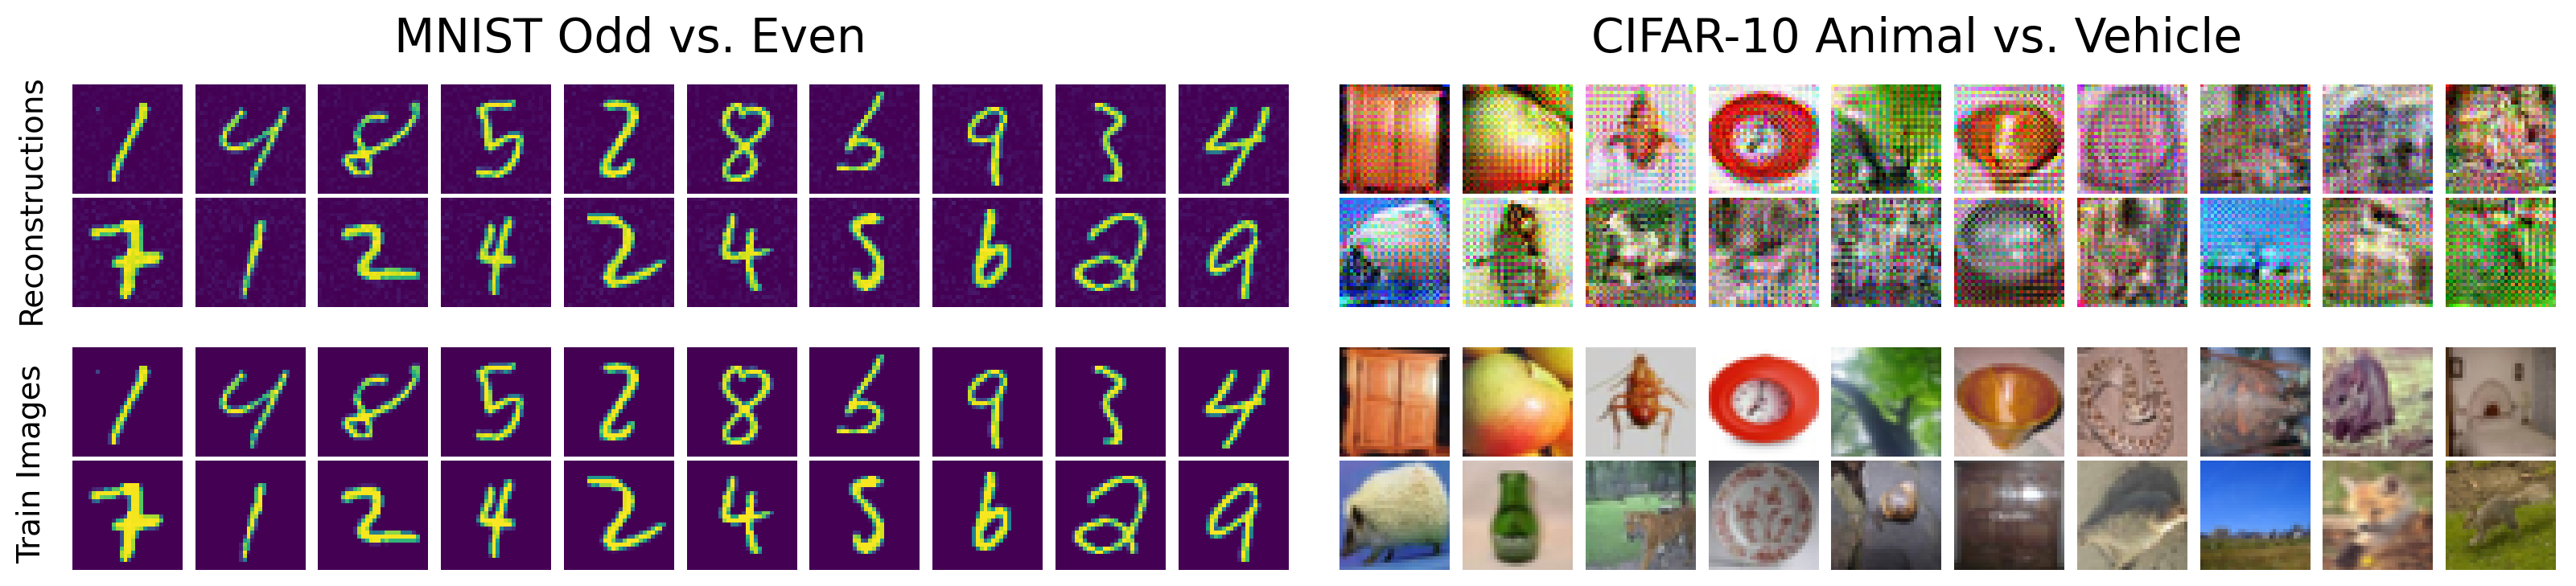

In [6]:
##### Loading MNIST reconstructions

recon_images = np.array(pickle.load(open('./example_mnist/reconstruction_amp_2.pkl', 'rb'))['images'])
training_set_dict = pickle.load(open('./example_mnist/training_set.pkl', 'rb'))
train_images = np.array(training_set_dict['train_images'])
train_mean = np.array(training_set_dict['train_mean'])

recon_images = correct_mean(recon_images, train_mean)
train_images = correct_mean(train_images, train_mean)

best_pairs = get_best_pairs(train_images, recon_images)

train_images_best = train_images[best_pairs[:, 0][:20]]
recon_images_ordered = recon_images[best_pairs[:, 1][:20]]

width_ratios = [1 for i in range(21)]
width_ratios[10] = 0.3

fig, ax = plt.subplots(5, 21, dpi = 200, figsize = (20, 4), gridspec_kw = {'height_ratios':[1,1,0.3,1,1], 'width_ratios': width_ratios})

plt.subplots_adjust(wspace=0.02,hspace=0.04)


plot_images(recon_images_ordered, fig_ax = (fig, ax))
plot_images(train_images_best, fig_ax = (fig, ax[3:]))


##### Loading CIFAR-10 reconstructions

recon_images = np.array(pickle.load(open('./fine_tune/cub200/reconstruction_amp_2.pkl', 'rb'))['images'])
training_set_dict = pickle.load(open('./fine_tune/cub200/training_set.pkl', 'rb'))
train_images = np.array(training_set_dict['train_images'])
train_mean = np.array(training_set_dict['train_mean'])

recon_images = correct_mean(recon_images, train_mean)
train_images = correct_mean(train_images, train_mean)

best_pairs = get_best_pairs(train_images, recon_images)

train_images_best = train_images[best_pairs[:, 0][:20]]
recon_images_ordered = recon_images[best_pairs[:, 1][:20]]


plot_images(recon_images_ordered, fig_ax = (fig, ax[:, 11:]))
plot_images(train_images_best, fig_ax = (fig, ax[3:, 11:]))

for a in range(21):
    ax[2, a].axis('off')
    
for a in range(5):
    ax[a, 10].axis('off')

fig.text(0.3, 0.93, 'MNIST Odd vs. Even', fontsize = 21, ha = 'center')
fig.text(0.7, 0.93, 'CIFAR-10 Animal vs. Vehicle', fontsize = 21, ha = 'center')

fig.text(0.114, 0.70, 'Reconstructions', ha = 'center', fontsize = 14, rotation = 90, va = 'center')

fig.text(0.114, 0.29, 'Train Images', ha = 'center', fontsize = 14, rotation = 90, va = 'center')

plt.savefig('Basic

# Making Reconstruction Curves

In [45]:
#Function for computing the reconstruction curve
def get_recon_curve(train_images, recons, return_index = False):
    train_images_flattened = train_images.reshape(train_images.shape[0], -1)
    recon_flattened = recons.reshape(recons.shape[0], -1)
    dists = np.sqrt(np.sum((train_images_flattened[:, None] - recon_flattened[None])**2, -1))
    dists = np.array(dists)

    best_pairs = []

    pair_dists = []
    indices = []


    while(len(best_pairs) < train_images.shape[0]):
        loc = np.unravel_index(dists.argmin(), dists.shape)
        best_pairs.append([loc[0], loc[1]])

        pair_dists.append(dists[loc])

        dists[loc[0]] = np.inf
        dists[:, loc[1]] = np.inf
        indices.append(loc[0])
        
    if return_index:
        return pair_dists, indices
    return pair_dists

In [48]:
##### Loading MNIST reconstructions

recon_images = np.array(pickle.load(open('./example_mnist/reconstruction_amp_2.pkl', 'rb'))['images'])
training_set_dict = pickle.load(open('./example_mnist/training_set.pkl', 'rb'))
train_images = np.array(training_set_dict['train_images'])
train_mean = np.array(training_set_dict['train_mean'])

print(train_images.shape)

recon_curve_mnist = get_recon_curve(train_images, recon_images)

##### Loading CIFAR reconstructions

recon_images = np.array(pickle.load(open('./example_cifar/reconstruction_amp_2.pkl', 'rb'))['images'])
training_set_dict = pickle.load(open('./example_cifar/training_set.pkl', 'rb'))
train_images = np.array(training_set_dict['train_images'])
train_mean = np.array(training_set_dict['train_mean'])

print(train_images.shape)

recon_curve_cifar = get_recon_curve(train_images, recon_images)



(200, 28, 28, 1)
(200, 32, 32, 3)


Text(0.5, 1.08, 'Reconstruction Curves for N = 200, W = 2048')

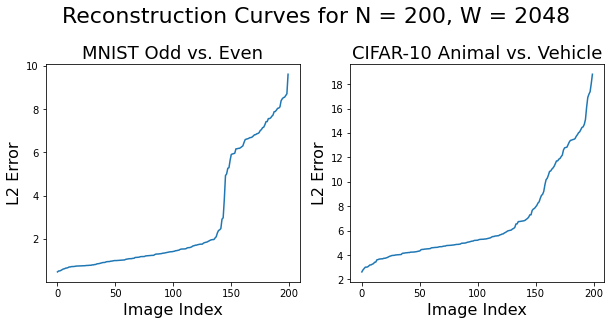

In [53]:
fig, ax = plt.subplots(1,2, figsize = (10, 4))


ax[0].plot(recon_curve_mnist)
ax[1].plot(recon_curve_cifar)

for i in range(2):
    ax[i].set_ylabel('L2 Error', fontsize = 16)
    ax[i].set_xlabel('Image Index', fontsize = 16)
    
ax[0].set_title('MNIST Odd vs. Even', fontsize = 18)
ax[1].set_title('CIFAR-10 Animal vs. Vehicle', fontsize = 18)

plt.suptitle('Reconstruction Curves for N = 200, W = 2048', fontsize = 22, y = 1.08)